In [140]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from typing import Literal

import ipywidgets as widgets
from ipywidgets import GridBox, Button
from IPython.display import display, clear_output

import os
from datetime import datetime

### Read progress and records files

In [141]:
environments = {
    "water_tank": {
        "base_dir": "../logs/ppo/double_water_tank/trainings_2",
        "tracked_point": "x2",
    },
    "CPAP": {
        "base_dir": "../logs/ppo/CPAP/trainings",
        "tracked_point": "x3",
    },
}

env_name: Literal["water_tank", "CPAP"] = "water_tank"
env = environments[env_name]
base_dir = env["base_dir"]
tracked_point = env["tracked_point"]

index = None # -1
folder_names = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))][:index]
def folder_to_datetime(folder_name):
    """
    Função para converter o nome da pasta em um objeto datetime.
    Combinada com max(), é possível ordenar de forma decrescente pastas por data da mais recente (max) para antiga (min).
    O nome da pasta DEVE estar no formato '%d-%m-%H%M' ou ter uma substring nesse formato para funcionar corretamente.
    """
    pattern = r'\d{2}-\d{2}-\d{4}'
    match = re.search(pattern, folder_name)
    if match:
        date_str = match.group(0)
        date_str = datetime.strptime(date_str, '%d-%m-%H%M')
        return (date_str.month, date_str.day)
    else:
        raise ValueError(f"Formato de data inválido na pasta: {folder_name}")


folder_names.sort(key=folder_to_datetime)

latest_folder = folder_names[-1] # max(folder_names, key=folder_to_datetime)
selected_folder = latest_folder
selected_index = len(folder_names) - 1


# print(folder_names)
# print(f"A pasta mais recente é: {latest_folder}")

In [142]:
def are_required_files_present(folder: str):
    return all([
        os.path.exists(f"{base_dir}/{folder}/progress.csv"),
        os.path.exists(f"{base_dir}/{folder}/records.csv"),
        # os.path.exists(f"{base_dir}/{folder}/only_pid_records.csv"),
    ])

In [143]:
def load_dfs(folder: str) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:

    if not are_required_files_present(folder):
        raise FileNotFoundError("Arquivos necessários não encontrados.")
    
    progress_df = pd.read_csv(f"{base_dir}/{folder}/progress.csv")
    rec_df = pd.read_csv(f"{base_dir}/{folder}/records.csv")

    # Find the index of the last episode start
    mask = rec_df["steps_in_episode"] == 1
    start_episode_indexes = mask[mask].index.to_list()
    last_episode_start_idx = start_episode_indexes[-1]

    # Filter the dataframe for the last episode
    last_episode_df = rec_df.loc[last_episode_start_idx:]

    return progress_df, rec_df, last_episode_df

progress_df, rec_df, last_episode_df = load_dfs(latest_folder)

In [144]:
progress_df.head()

,train/iteration
0,1


In [145]:
rec_df

,x1,x2,y_ref,z_t,PID_action,PPO_action,combined_action,reward,error,steps_in_episode
0,5.617249,6.474410,3.0,-3.474410,-30.710773,0.779865,-30.710773,-12.071526,-3.474410,1
1,5.197324,6.443508,3.0,-6.917918,-30.574810,-0.044186,-30.574810,-11.857748,-3.443508,2
2,4.793401,6.397682,3.0,-10.315600,-30.302871,-1.000000,-30.302871,-11.544246,-3.397682,3
3,4.405490,6.337445,3.0,-13.653046,-29.899605,0.787965,-29.899605,-11.138542,-3.337445,4
4,4.033607,6.263296,3.0,-16.916342,-29.369519,-0.329590,-29.369519,-10.649101,-3.263296,5
...,...,...,...,...,...,...,...,...,...,...
1995,1.974996,1.845364,2.0,25.000000,1.417116,1.000000,1.417116,-0.023912,0.154636,1996
1996,1.998159,1.853675,2.0,25.000000,1.360794,0.143201,1.360794,-0.021411,0.146325,1997
1997,2.005240,1.862899,2.0,25.000000,1.287663,-0.203381,1.287663,-0.018797,0.137101,1998
1998,1.995641,1.871968,2.0,25.000000,1.206485,1.000000,1.206485,-0.016392,0.128032,1999


# Separa as linhas por episódio

In [146]:
mask = rec_df["steps_in_episode"] == 1
start_episode_indexes = mask[mask].index.to_list()

first_episode_start = start_episode_indexes[0]
first_episode_end = start_episode_indexes[1] - 1 if len(start_episode_indexes) > 1 else len(rec_df) - 1

last_episode_start = start_episode_indexes[-1]
last_episode_end = len(rec_df) - 1

first_episode = rec_df.iloc[first_episode_start:first_episode_end+1]
last_episode = rec_df.iloc[last_episode_start:last_episode_end+1]

episodes_count = len(start_episode_indexes)

In [147]:
first_episode

,x1,x2,y_ref,z_t,PID_action,PPO_action,combined_action,reward,error,steps_in_episode
0,5.617249,6.474410,3.0,-3.474410,-30.710773,0.779865,-30.710773,-12.071526,-3.474410,1
1,5.197324,6.443508,3.0,-6.917918,-30.574810,-0.044186,-30.574810,-11.857748,-3.443508,2
2,4.793401,6.397682,3.0,-10.315600,-30.302871,-1.000000,-30.302871,-11.544246,-3.397682,3
3,4.405490,6.337445,3.0,-13.653046,-29.899605,0.787965,-29.899605,-11.138542,-3.337445,4
4,4.033607,6.263296,3.0,-16.916342,-29.369519,-0.329590,-29.369519,-10.649101,-3.263296,5
...,...,...,...,...,...,...,...,...,...,...
1995,1.974996,1.845364,2.0,25.000000,1.417116,1.000000,1.417116,-0.023912,0.154636,1996
1996,1.998159,1.853675,2.0,25.000000,1.360794,0.143201,1.360794,-0.021411,0.146325,1997
1997,2.005240,1.862899,2.0,25.000000,1.287663,-0.203381,1.287663,-0.018797,0.137101,1998
1998,1.995641,1.871968,2.0,25.000000,1.206485,1.000000,1.206485,-0.016392,0.128032,1999


In [148]:
last_episode

,x1,x2,y_ref,z_t,PID_action,PPO_action,combined_action,reward,error,steps_in_episode
0,5.617249,6.474410,3.0,-3.474410,-30.710773,0.779865,-30.710773,-12.071526,-3.474410,1
1,5.197324,6.443508,3.0,-6.917918,-30.574810,-0.044186,-30.574810,-11.857748,-3.443508,2
2,4.793401,6.397682,3.0,-10.315600,-30.302871,-1.000000,-30.302871,-11.544246,-3.397682,3
3,4.405490,6.337445,3.0,-13.653046,-29.899605,0.787965,-29.899605,-11.138542,-3.337445,4
4,4.033607,6.263296,3.0,-16.916342,-29.369519,-0.329590,-29.369519,-10.649101,-3.263296,5
...,...,...,...,...,...,...,...,...,...,...
1995,1.974996,1.845364,2.0,25.000000,1.417116,1.000000,1.417116,-0.023912,0.154636,1996
1996,1.998159,1.853675,2.0,25.000000,1.360794,0.143201,1.360794,-0.021411,0.146325,1997
1997,2.005240,1.862899,2.0,25.000000,1.287663,-0.203381,1.287663,-0.018797,0.137101,1998
1998,1.995641,1.871968,2.0,25.000000,1.206485,1.000000,1.206485,-0.016392,0.128032,1999


### Plot Train over iteraçtion

In [149]:
def plot_progress(folder: str, save = False):
    # Plotting train/loss vs train/iteration
    plt.figure(figsize=(12, 6))
    plt.plot(progress_df['train/iteration'], progress_df['train/loss'], label='Train Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Train Loss vs. Iteration')
    plt.legend()
    plt.grid(True)
    if save:
        plt.savefig(f"{base_dir}/{folder}/loss_over_iteration.png")
    else: 
        plt.show()

# plot_progress(latest_folder, save = True)

### Plote reward over steps

In [150]:
def plot_rewards(folder: str, save=False):
    # Plotting reward vs steps
    plt.figure(figsize=(12, 6))
    plt.plot(last_episode_df['steps_in_episode'], last_episode_df['reward'], label='Reward')
    plt.xlabel('Steps')
    plt.ylabel('Reward')
    plt.title('Reward vs. Steps')
    plt.legend()
    plt.grid(True)
    if save:
        plt.savefig(f"{base_dir}/{folder}/reward_over_last_episode_steps.png")
    else:
        plt.show()

# plot_rewards(latest_folder, save=True)

### Plot Set point curve

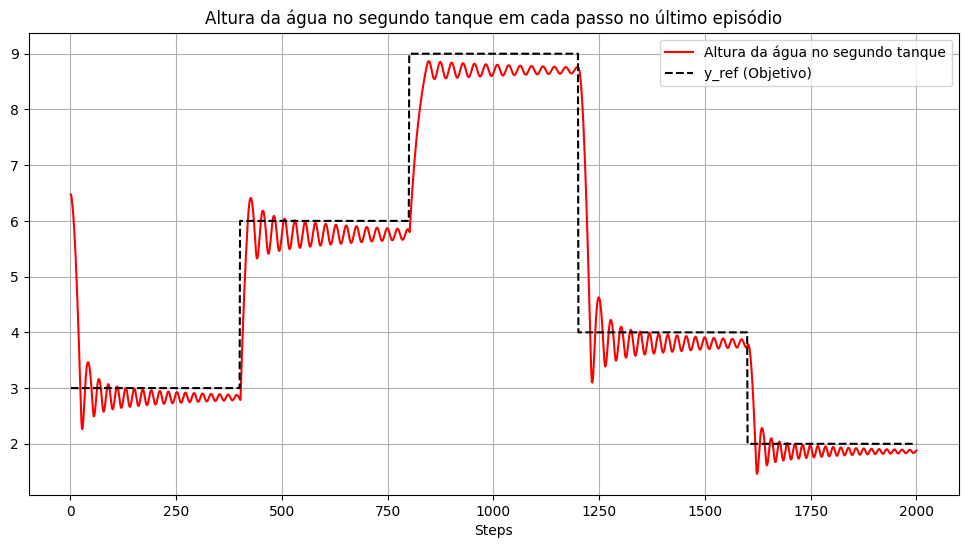

In [151]:
def plot_tracking(folder: str, save: bool = False):
    # Plot y_ref vs steps_in_episode
    plt.figure(figsize=(12, 6))
    if env_name == "water_tank":
        plt.title('Altura da água no segundo tanque em cada passo no último episódio')
        tracked_point_label = "Altura da água no segundo tanque"
    else:
        plt.title('Pressão exercida pelo CPAP')
        tracked_point_label = "Pressão"
    plt.plot(last_episode_df['steps_in_episode'], last_episode_df[tracked_point], label=tracked_point_label, color='red')
    plt.plot(last_episode_df['steps_in_episode'], last_episode_df['y_ref'], '--', label='y_ref (Objetivo)', color='black')
    plt.xlabel('Steps')
    plt.ylabel('')
    plt.legend()
    plt.grid(True)
    if save:
        plt.savefig(f"{base_dir}/{folder}/tracking.png")
    else:
        plt.show()

plot_tracking(latest_folder, save=False)

### Ação do PPO e PID durante o último episódio

In [152]:
def plot_action_per_steps(folder: str, save: bool = False, separated: bool = True):

    if (separated):
        # Plotting action vs steps in the last episode
        plt.figure(figsize=(12, 6))
        plt.plot(last_episode_df['steps_in_episode'], last_episode_df['PID_action'], label='PID_action', color='blue')
        plt.xlabel('Steps')
        plt.ylabel('Action')
        plt.title('Ação do controlador PID em cada passo no último episódio')
        plt.legend()
        plt.grid(True)
        if save:
            plt.savefig(f"{base_dir}/{folder}/PID_action.png")
        else:
            plt.show()

        # Plotting action vs steps in the last episode
        plt.figure(figsize=(12, 6))
        plt.plot(last_episode_df['steps_in_episode'], last_episode_df['PPO_action'], label='PPO_action', color='red')
        plt.xlabel('Steps')
        plt.ylabel('Action')
        plt.title('Ação do controlador PPO em cada passo no último episódio')
        plt.legend()
        plt.grid(True)
        if save:
            plt.savefig(f"{base_dir}/{folder}/PPO_action.png")
        else:
            plt.show()
    else:
        # Plotting action vs steps in the last episode
        plt.figure(figsize=(12, 6))
        plt.plot(last_episode_df['steps_in_episode'], last_episode_df['PID_action'], label='PID_action', color='blue')
        plt.plot(last_episode_df['steps_in_episode'], last_episode_df['PPO_action'], label='PPO_action', color='red')
        # plt.plot(last_episode_df['steps_in_episode'], last_episode_df['action'], label='Action', color='black')
        plt.xlabel('Steps')
        plt.ylabel('Action')
        plt.title('Ação em cada passo no último episódio')
        plt.legend()
        plt.grid(True)
        if save:
            plt.savefig(f"{base_dir}/{folder}/combined_action.png")
        else:
            plt.show()

# plot_action_per_steps(latest_folder, save=True)

# Função para exibir a grade de pastas

In [153]:
import ipywidgets as widgets
from IPython.display import display, clear_output

def display_folders_grid(folder_names: list[str], selected_indices: int = 0) -> widgets.VBox:
    num_cols = 5
    previous_selected = [selected_indices]
    
    def on_button_click(b: widgets.Button):
        global selected_folder
        selected_folder = b.description

        global progress_df, rec_df, last_episode_df
        progress_df, rec_df, last_episode_df = load_dfs(selected_folder)

        previous_selected.append(buttons.index(b))
        if len(previous_selected) > 2:
            previous_selected.pop(0)
        
        # Atualiza cor dos botões
        buttons[previous_selected[0]].button_style = '' 
        buttons[previous_selected[1]].button_style = 'success'

        clear_output(wait=True)  # Limpar as saídas anteriores
        display(grid)            # Reexibir a grade de botões
        display(save_button)     # Reexibir o botão de salvar

        plot_tracking(selected_folder, save=False)
        plot_rewards(selected_folder, save=False)
        plot_action_per_steps(selected_folder, save=False)

    def on_save_click(b: widgets.Button):
        should_save = True  # Ativar o modo de salvar
        
        if 'selected_folder' in globals():
            plot_tracking(selected_folder, save=should_save)
            plot_rewards(selected_folder, save=should_save)
            plot_action_per_steps(selected_folder, save=should_save)
            print(f"Plots salvos para {selected_folder}!")
        else:
            print("Nenhuma pasta selecionada ainda!")

    # Criar os botões para as pastas
    buttons = []
    for i, folder in enumerate(folder_names):
        button = widgets.Button(description=folder, layout=widgets.Layout(width='auto', height='auto'))
        button.on_click(on_button_click)
        buttons.append(button)
    
    # Marcar o primeiro botão como ativo
    buttons[selected_indices].button_style = 'success'  
    
    # Criar o botão de salvar
    save_button = widgets.Button(description="Salvar Gráficos", button_style='info')
    save_button.on_click(on_save_click)

    # Criar a grade de botões
    grid = widgets.GridBox(
        children=buttons,
        layout=widgets.Layout(grid_template_columns=f'repeat({num_cols}, 1fr)')
    )

    display(save_button)
    display(grid)
    display(save_button)


GridBox(children=(Button(button_style='success', description='05-03-1646-optuna-trial_0_best', layout=Layout(h…

Button(button_style='info', description='Salvar Gráficos', style=ButtonStyle())

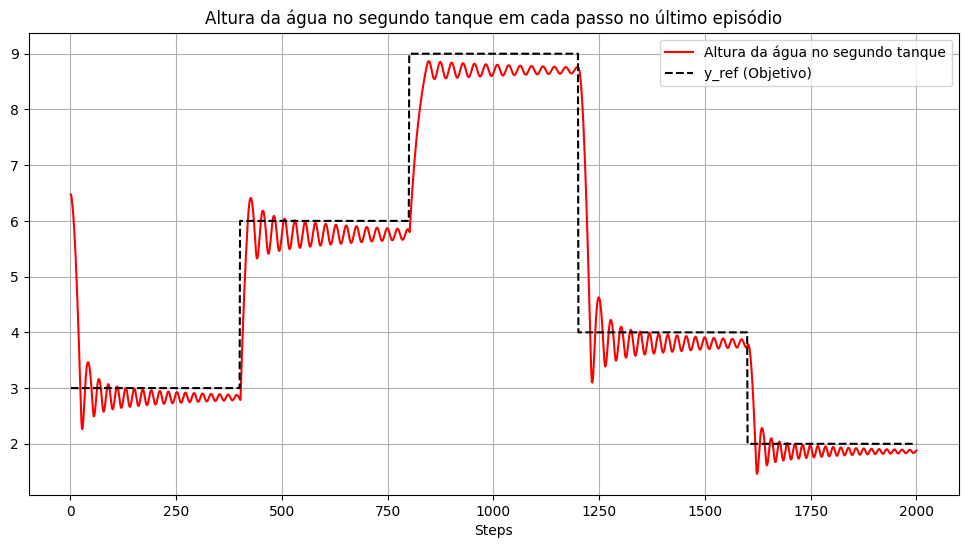

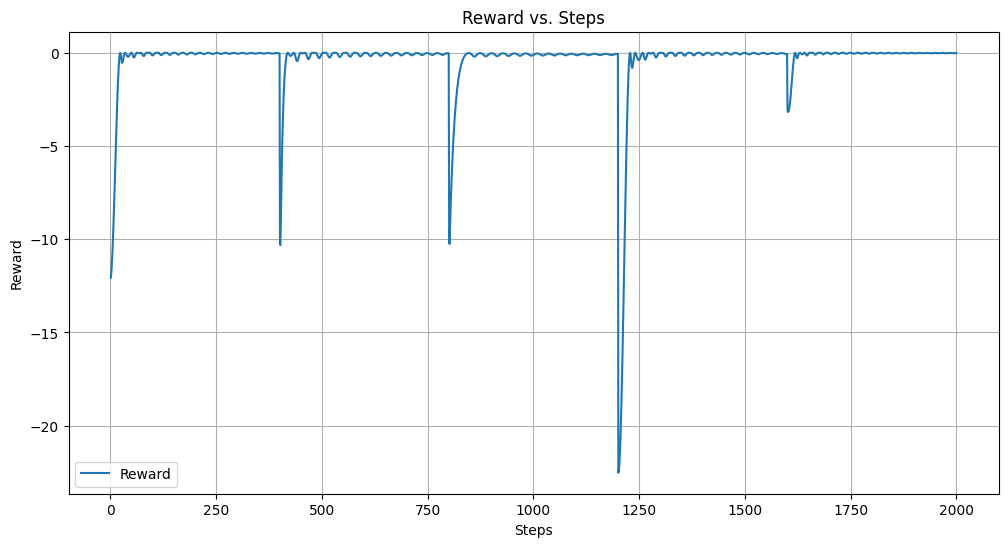

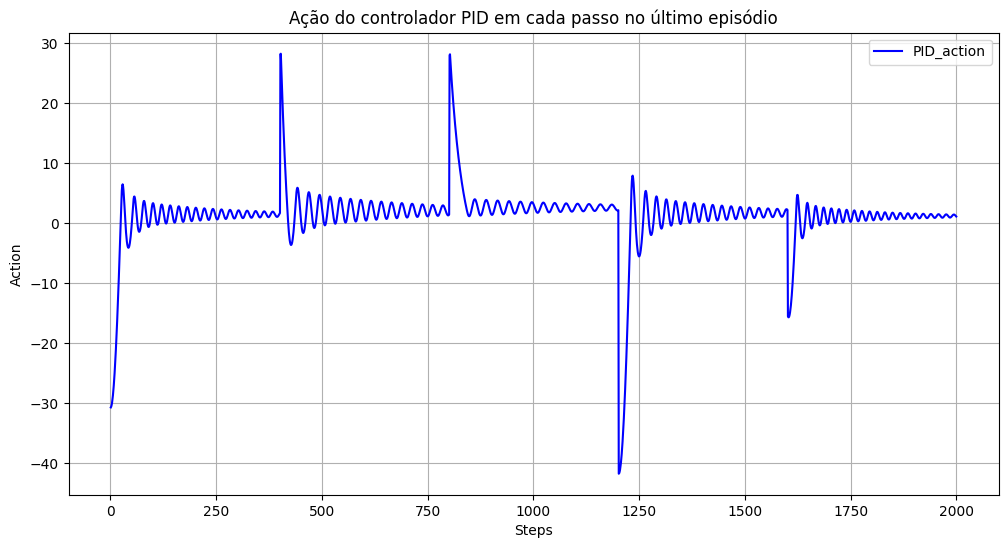

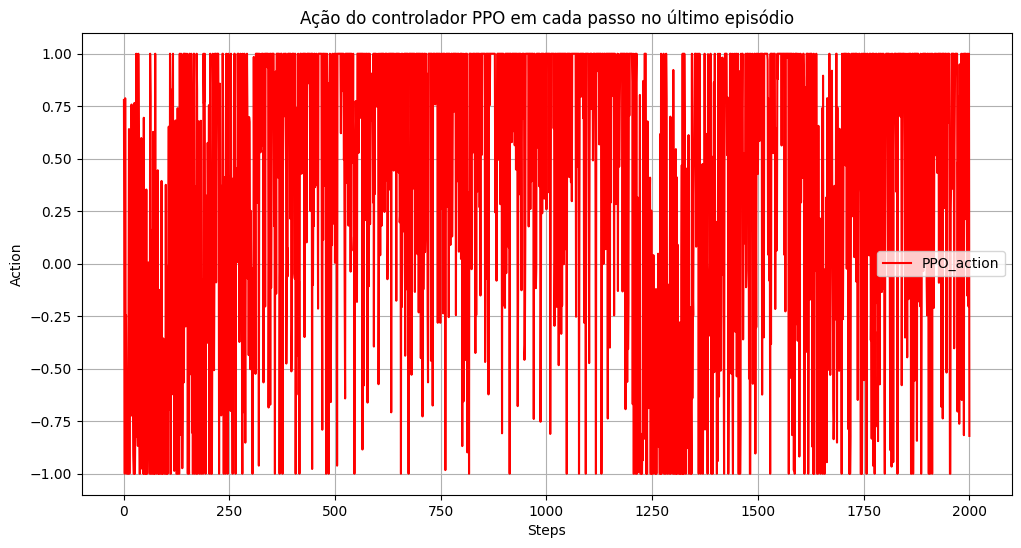

Plots salvos para 05-03-1646-optuna-trial_0_best!


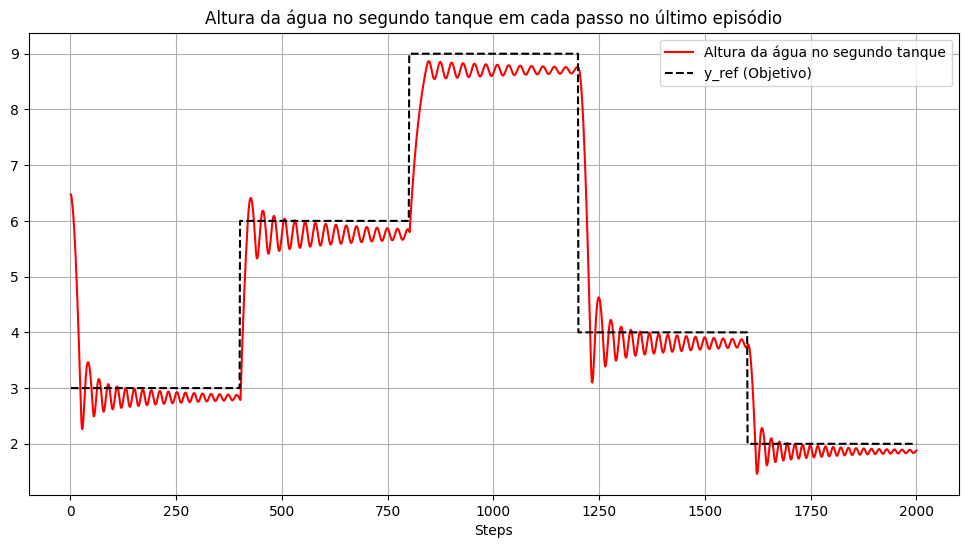

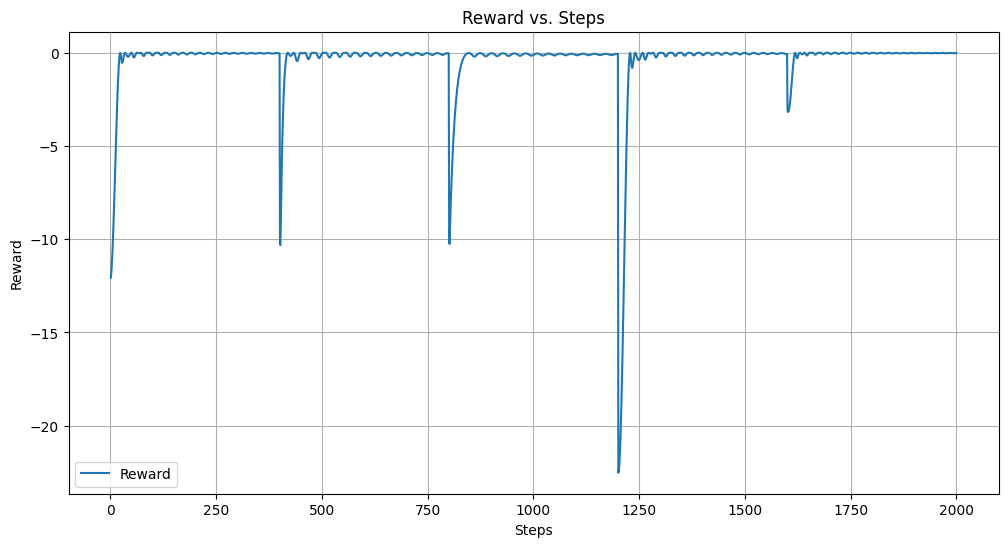

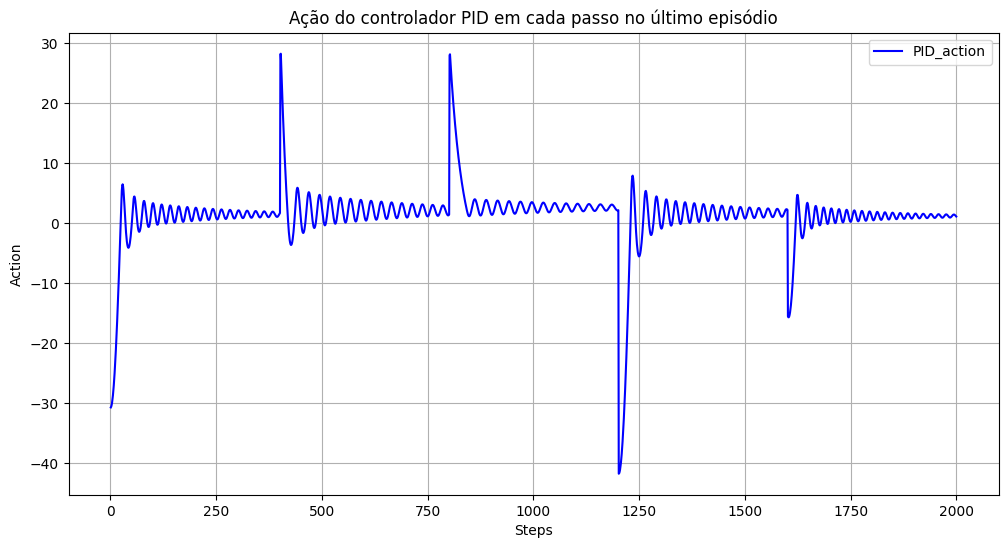

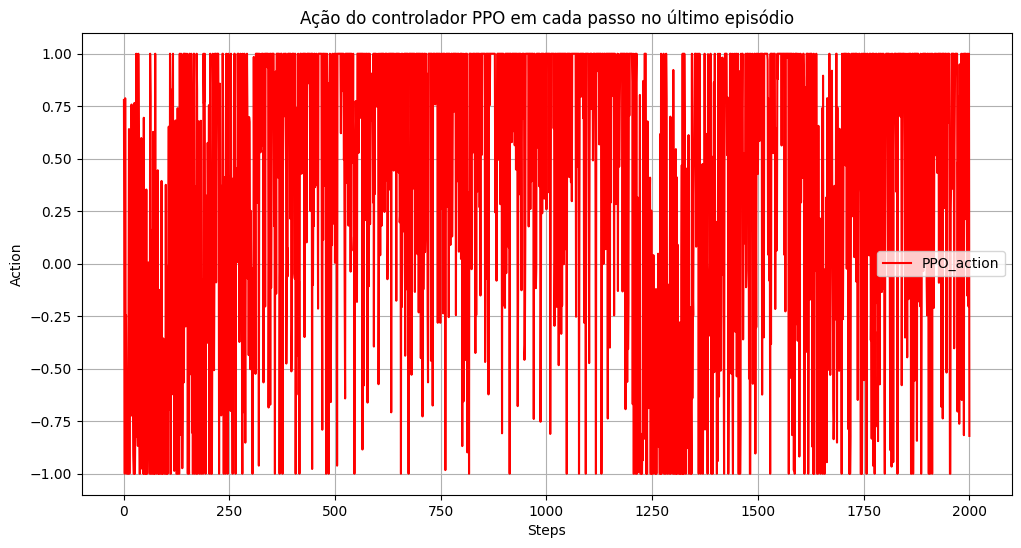

In [ ]:
# Uncomment to use widget 
display_folders_grid(folder_names, selected_index)